In [1]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
import test_functions

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = Variable(torch.linspace(0, 1, 11))
# True function is sin(2*pi*x) with Gaussian noise N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable
from scipy.stats import norm
from scipy.optimize import minimize

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Our mean function is constant in the interval [-1,1]
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        # We use the RBF kernel as a universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 5))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Return moddl output as GaussianRandomVariable
        return GaussianRandomVariable(mean_x, covar_x)

In [11]:
#Adaptation of acquisition maximization from Python BayesOpt implementation found at
#https://github.com/fmfn/BayesianOptimization

def acq_max(ac, gp, y_max, dim, bounds, random_state, n_warmup=1000, n_iter=10):
    """
    A function to find the maximum of the acquisition function
    It uses a combination of random sampling (cheap) and the 'L-BFGS-B'
    optimization method. First by sampling `n_warmup` (1e5) points at random,
    and then running L-BFGS-B from `n_iter` (250) random starting points.
    Parameters
    ----------
    :param ac:
        The acquisition function object that return its point-wise value.
    :param gp:
        A gaussian process fitted to the relevant data.
    :param y_max:
        The current maximum known value of the target function.
    :param bounds:
        The variables bounds to limit the search of the acq max.
    :param random_state:
        instance of np.RandomState random number generator
    :param n_warmup:
        number of times to randomly sample the aquisition function
    :param n_iter:
        number of times to run scipy.minimize
    Returns
    -------
    :return: x_max, The arg max of the acquisition function.
    """
    
    # Warm up with random points
    #x_tries = Variable(torch.linspace(bounds[0][0], bounds[0][1], n_warmup))
    
    #ys = ac(x_tries, gp, y_max, xi=0.01).data.numpy()
    #x_max = x_tries.data.numpy()[ys.argmax()]
    #max_acq = float(ys.max())
    
    #Initialize
    x_max = Variable(torch.Tensor(1, dim).uniform_(bounds[0][0], bounds[0][1]))
    max_acq = ac(x_max, gp, y_max, xi=0.5)

    # Explore the parameter space more throughly
    x_seeds = Variable(torch.Tensor(n_iter*dim, dim).uniform_(bounds[0][0], bounds[0][1]))
    
    for x_try in x_seeds:
        x_try = x_try.view(1, dim)

        # Find the minimum of minus the acquisition function
        res = minimize(lambda x: -ac(Variable(torch.from_numpy(x).float()).view(1, dim), gp, y_max, xi=0.5),
                       x_try,
                       bounds=bounds,
                       method="L-BFGS-B")

        # See if success
        if not res.success:
            continue
           
        # Store it if better than previous minimum(maximum).
        if max_acq is None or float((-res.fun[0]).gt(max_acq)):
            x_max = Variable(torch.from_numpy(np.clip(res.x, bounds[0][0], bounds[0][1])).float()) 
            max_acq = float(-res.fun[0])

    # Clip output to make sure it lies within the bounds. Due to floating
    # point technicalities this is not always the case.
    return x_max.view(1, dim)

In [12]:
class Bayes_opt:
    
    def __init__(self, func, dim, step_num):
        
        self.dim = dim
        self.bounds = [(0,1)]*dim
        self.step_num = step_num    
        self.obj_func = func
        self.model_GP = None
        
        
    def _ei(self, x, gp, y_max, xi):
 
        predict_pt = gp(x)
        mean = predict_pt.mean()
        std = torch.sqrt(predict_pt.var())
        z = (mean - y_max - xi)/std
    
        return (
            (mean - y_max - xi) * Variable(torch.from_numpy(norm.cdf(z.data)).float()) + 
            std * Variable(torch.from_numpy(norm.pdf(z.data)).float())
            )        
    
    def _update_GP(self, train_x, train_y):
        
        likelihood = GaussianLikelihood(log_noise_bounds=(-5, 5))
        
        model = ExactGPModel(train_x.data, train_y.data, likelihood)
        model.train()
        likelihood.train()
        
        # Use the adam optimizer
        optimizer = torch.optim.Adam([
            {'params': model.parameters()},  # Includes GaussianLikelihood parameters
        ], lr=0.1)

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        training_iter = 50
        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()
            #print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
                #i + 1, training_iter, loss.data[0],
                #model.covar_module.log_lengthscale.data[0, 0],
                #model.likelihood.log_noise.data[0]
            #))
            optimizer.step()
    
        # Put model and likelihood into eval mode
        model.eval()
        likelihood.eval()

        return model
        
        
    def optimize(self, mode="compact"):
        
        #Allocate space for iterates, initialize algorithm
        start_num = 2
        self.sample_pts = Variable(torch.zeros(self.step_num, self.dim))     
        self.sample_vals = Variable(torch.zeros(self.step_num))
        start_pts = Variable(torch.rand(start_num, self.dim))
        start_vals = self.obj_func(start_pts)
        self.sample_pts[:start_num] = start_pts
        self.sample_vals[:start_num] = start_vals
        self.opt_val = torch.min(start_vals.data)
        ind = torch.min(start_vals.data, 0)[1]
        self.opt_soln = start_pts[ind]

        self.model_GP = self._update_GP(start_pts, start_vals)
        
        if mode=="eval":
            self.obj_hist = Variable(torch.zeros(step_num))
            self.obj_hist[:start_num] = self.opt_val

        print("GP initiated")
        
        for t in range(start_num, self.step_num):
            
            if t%10 == 0: print(t, ': ', self.opt_val)
            
            #Get next point from acquisition function, evaluate objective
            new_pt = acq_max(ac=self._ei, gp=self.model_GP, y_max=self.opt_val, 
                             dim=self.dim, bounds=self.bounds, random_state=np.random.RandomState())
            new_val = float(self.obj_func(new_pt))
            self.sample_pts[t] = new_pt
            self.sample_vals[t] = new_val
            
            if new_val > self.opt_val:
                self.opt_val = new_val
                self.opt_soln = new_pt
                
            if mode=="eval":
                self.obj_hist[t] = self.opt_val
                
            #Update GP with new observation
            self.model_GP = self._update_GP(self.sample_pts[:t+1], self.sample_vals[:t+1])

GP initiated
10 :  2.4179000854492188
20 :  2.4179000854492188
30 :  2.4179000854492188
40 :  2.4179000854492188
50 :  2.4179000854492188


2.4179000854492188

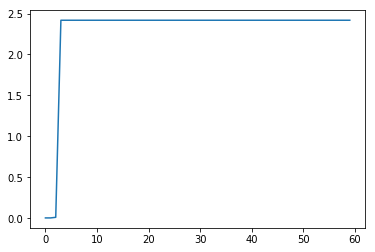

In [13]:
step_num = 60

test = Bayes_opt(func=test_functions.hartmann6d, dim=6, step_num=step_num)

test.optimize(mode="eval")

plt.plot(range(step_num), test.obj_hist.data.numpy())

test.opt_val

NameError: name 'bayes_opt' is not defined

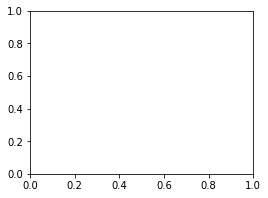

In [164]:
# Put model and likelihood into eval mode
model = test.model_GP
likelihood = GaussianLikelihood(log_noise_bounds=(-5, 5))

model.eval()
likelihood.eval()

# Initialize plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points are regularly spaced along [0,1] every 0.02
test_x = Variable(torch.linspace(0, 1, 51))
# Make predictions by feeding model through likelihood
with gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# Define plotting function
def ax_plot(ax, rand_var, title):
    
    rand_var = bayes_opt.model_GP
    train_x = bayes_opt.sample_pts
    train_y = bayes_opt.sample_vals
    
    # Get upper and lower confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    #Plot opt soln
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)
# Plot the predictions
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')